# Evaluate

hist 파일을 넣어 주시면 학습 그래프를 볼 수 있습니다 ^^

In [14]:
HIST_PATH = 'results/crnn_history.pkl'

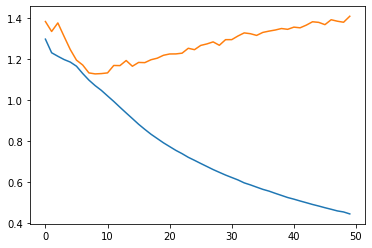

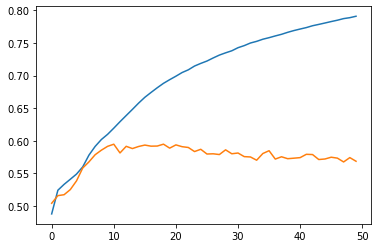

In [15]:
import pickle
import matplotlib.pyplot as plt

hist = pickle.load(open(HIST_PATH, 'rb'))
plt.plot(hist['train_loss'])
plt.plot(hist['valid_loss'])
plt.savefig('1.jpg')
plt.show()

plt.plot(hist['train_score'])
plt.plot(hist['valid_score'])
plt.savefig('1_1.jpg')
plt.show()

# Demo

## Load Library

In [1]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Choose the set of labels

아래 라벨 목록을 보시고 SET_ID에 원하는 LABEL을 입력합니다 ^^ (Model이 학습된 라벨과 동일해야함)

In [3]:
SET_ID = "A"

In [4]:
entire_label = ['Sad', 'Thick', 'Warm', 'Clear', 'Dynamic', 'Energetic', 'Speech-Like', 'Sharp', 'Falsetto', 'Robotic/Artificial', 
                     'Whisper/Quiet', 'Delicate', 'Passion', 'Emotional', 'Mid-Range', 
                     'High-Range', 'Compressed', 'Sweet', 'Soulful/R&B', 'Stable', 
                     'Rounded', 'Thin', 'Mild/Soft', 'Breathy', 'Pretty', 
                     'Young', 'Dark', 'Husky/Throaty', 'Bright', 'Vibrato', 
                     'Pure', 'Male', ' Ballad', 'Rich', 'Low-Range', 
                     'Shouty', 'Cute', 'Relaxed', 'Female', 'Charismatic', 
                     'Lonely', 'Embellishing']
                     
sets = {}
# ALL
sets['X'] = ['Sad', 'Thick', 'Warm', 'Clear', 'Dynamic', 'Energetic', 'Speech-Like', 'Sharp', 'Falsetto', 'Robotic/Artificial', 
            'Whisper/Quiet', 'Delicate', 'Passion', 'Emotional', 'Mid-Range', 
            'High-Range', 'Compressed', 'Sweet', 'Soulful/R&B', 'Stable', 
            'Rounded', 'Thin', 'Mild/Soft', 'Breathy', 'Pretty', 
            'Young', 'Dark', 'Husky/Throaty', 'Bright', 'Vibrato', 
            'Pure', 'Male', ' Ballad', 'Rich', 'Low-Range', 
            'Shouty', 'Cute', 'Relaxed', 'Female', 'Charismatic', 
            'Lonely', 'Embellishing']
# By OH!
sets['A'] = ['Rounded', 'Pretty', 'Delicate', 'Sharp', 'Passion', 
                'Lonely', 'Compressed', 'Pure', 'Sweet', 'Husky/Throaty', 
                'Rich', 'Energetic', 'Young', 'Robotic/Artificial', 'Clear', 
                'Thin', 'Thick', 'Mild/Soft', 'Bright', 'Charismatic',
                'Embellishing', 'Breathy', 'Dynamic', 'Cute', 'Sad',
                'Stable', 'Emotional', 'Warm', 'Relaxed', 'Dark']
# Technique & Low-level Timbre
sets['B'] = ['Male', 'Female', 'Whisper/Quiet', 'Shouty', 'Vibrato', 
                'Falsetto', 'Speech-like', 'Compressed', 'Husky/Throaty', 'Thick', 
                'Thin', 'Sharp', 'Breathy', 'Stable']
# High level Timbre
sets['C'] = ['Lonely', 'Sad', 'Passion','Charismatic','Pretty',
            'Cute','Delicate','Emotional','Pure','Robotics/Artificial',
            'Embellishing','Sweet','Young','Compressed','Dynamic']


chosen_labels = [label for label in entire_label if label in sets[SET_ID]]
label_filter = torch.tensor([(label in sets[SET_ID]) for label in entire_label])

## Load Model

모델을 불러와주세요 ヾ(^▽^*)))

In [23]:
state_path = r"results/D_MSE_49.pt"
thres_path = r"results/D_MSE_49_threshold.pt"

state = torch.load(state_path, map_location=DEVICE)
THRESHOLDS = torch.load(thres_path, map_location=DEVICE)

In [24]:
class base_model(nn.Module):
    '''
    Base model from "Semantic Tagging of Singing Voices in Popular Music Recordings"
    input : spectrogram
    output : predicted tag distribution (one-hot encoded)
    '''
    def __init__(self, output_dim):
        super().__init__()
        self.conv_layers=nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.MaxPool2d(3, 3, ceil_mode=True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(3, 3, ceil_mode=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(3, 3, ceil_mode=True),
        )
        self.fc = nn.Linear(5*4*128, output_dim)
    
    def forward(self, x):
        output = self.conv_layers(x)
        output = self.fc(output.view(output.size(0),-1))
        return output


class drop_model(nn.Module):
    '''
    Base model from "Semantic Tagging of Singing Voices in Popular Music Recordings"
    input : spectrogram
    output : predicted tag distribution (one-hot encoded)
    '''
    def __init__(self, output_dim):
        super().__init__()
        self.conv_layers=nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.MaxPool2d(3, 3, ceil_mode=True),
            nn.Dropout2d(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(3, 3, ceil_mode=True),
            nn.Dropout2d(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(3, 3, ceil_mode=True),
            nn.Dropout2d(),
        )
        self.fc = nn.Linear(5*4*128, output_dim)
    
    def forward(self, x):
        output = self.conv_layers(x)
        output = self.fc(output.view(output.size(0),-1))
        return output

In [25]:
model = drop_model(len(chosen_labels)).to(DEVICE)
model.load_state_dict(state)

<All keys matched successfully>

## 1. Tagging

원하시는 음악을 넣어주세요~

실행 환경에 따라 wav파일만 될 수도 있습니다.~

In [26]:
FILE_PATH = r"likeme_a.wav"

In [22]:
import torchaudio

def get_mel_spectrogram(file_path, SR = 22050):
    audio, sr = torchaudio.load(file_path)
    audio = audio.mean(dim=0)
    audio = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SR)(audio)
    
    spec = torchaudio.functional.spectrogram(audio, n_fft=1024,
                                         hop_length=512, 
                                         pad=0, 
                                         win_length=1024,
                                         power=True,
                                         normalized=True,
                                         window = torch.hann_window(1024)
                                        )
    
    mel_scale = torchaudio.transforms.MelScale(n_mels=128, 
                                           sample_rate=22050, 
                                           f_min=20, 
                                           f_max=8000, 
                                           n_stft=spec.shape[0])
    mel_spec = mel_scale(spec)
    
    mel_spec = torch.log(1+10 * mel_spec).unsqueeze(0)
    
    return mel_spec

결과가 마음에 들지 않으면 아래 THRESHOLDS를 THRESHOLD + 1, THRESHOLD - 0.5 등 수정할 수 있습니다╰(艹皿艹 )

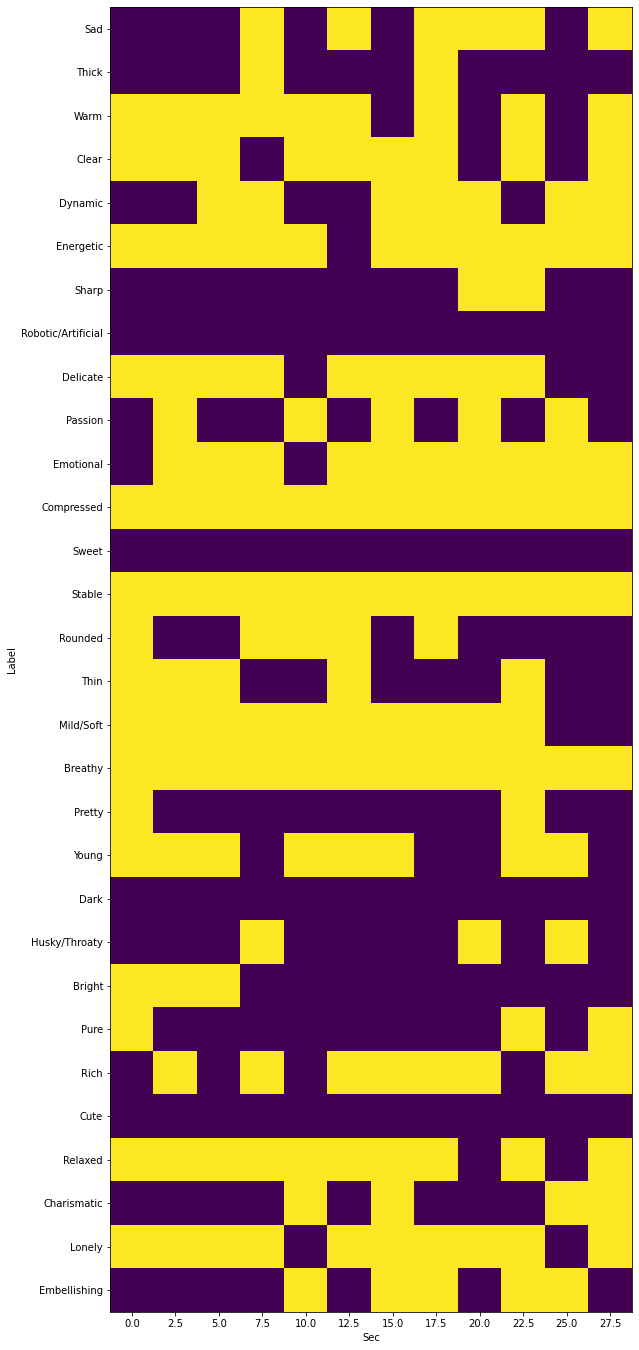

In [10]:
import torch.nn as nn
import matplotlib.pyplot as plt

mel_spec = get_mel_spectrogram(FILE_PATH, SR=22050)

mel_spec = mel_spec.to(DEVICE)
num_segs = mel_spec.size(-1)//107

outputs = torch.zeros(num_segs, len(chosen_labels)).to(DEVICE)

for i in range(num_segs):
    output = model(mel_spec[:,:,i*107:(i+1)*107].unsqueeze(0))
    outputs[i, :] = output[0]

prediction = (outputs > THRESHOLDS).to(int).T
plt.figure(figsize=(10,2*outputs.size(0)))
plt.imshow(prediction)
plt.ylabel("Label")
plt.xlabel("Sec")
plt.yticks(range(len(chosen_labels)), chosen_labels)
plt.xticks(range(outputs.size(0)), [2.5*n for n in range(outputs.size(0))])
plt.show()

## 2. Similarity (Searching)

inference 결과를 활용하여 가수와 가수 또는 사용자와 가수 간에 음색을 비교할 수 있는 척도 개발..

--- 미구현 ---